# Setting figure parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Custom Seaborn parameters for improved plot aesthetics
custom_params = {
    "xtick.direction": "in",           # xTick marks pointing inward
    "ytick.direction": "in",           # yTick marks pointing inward
    "lines.markeredgecolor": "k",      # Black edge color for markers
    "lines.markeredgewidth": 1.25,     # Edge width for markers
    "figure.dpi": 200,                 # High-resolution figure
    "text.usetex": True,               # Use LaTeX for text rendering
    "font.family": "serif"             # Serif font for a classic look
}

# Set Seaborn theme with custom parameters
sns.set_theme(context="talk", style="ticks", rc=custom_params)

# Opening a representative CSV file and initialising empty lists for collection of data

motherfolder = './results/'
result_file = ( 
    motherfolder + 
'N_10000000-tau_0.0001-g11_1.0-g12_2.2-g22_10.0-kappa_0.002-l_1.0-alpha_1.0-Ntrajectories_10' + 
'.csv' )
parameters = []
coefficients = []
errors = []
dlist = []
msd_q1 = []
msd_q2 = []
q1_hist = []
q1_bins = []
q2_list = []
q2_bins = []

# Filling lists with respective quantities for the representative CSV file

In [2]:
import pandas as pd

# File path setup
motherfolder = './results/'
result_file = (
    f'{motherfolder}N_10000000-tau_0.0001-g11_1.0-g12_2.0-g22_10.0-kappa_0.002-l_1.0-alpha_1.0-Ntrajectories_10.csv'
)

# Read the CSV file into a DataFrame
data = pd.read_csv(result_file)

# Extract the data into individual lists (columns)
parameters = data.iloc[:, 0].dropna().tolist()
coefficients = data.iloc[:, 1].dropna().tolist()
errors = data.iloc[:, 2].dropna().tolist()
dlist = data.iloc[:, 3].dropna().tolist()
msd_q1 = data.iloc[:, 4].dropna().tolist()
msd_q2 = data.iloc[:, 5].dropna().tolist()
q1_hist = data.iloc[:, 6].dropna().tolist()
q1_bins = data.iloc[:, 7].dropna().tolist()
q2_list = data.iloc[:, 8].dropna().tolist()
q2_bins = data.iloc[:, 9].dropna().tolist()


# Converting lists to nparrays for numpy nanagement

In [3]:
data_lists = [parameters, coefficients, errors, dlist, msd_q1, msd_q2, q1_hist, q1_bins, q2_list, q2_bins]

parameters, coefficients, errors, dlist, msd_q1, msd_q2, q1_hist, q1_bins, q2_list, q2_bins = [np.asarray(lst) for lst in data_lists]


In [4]:
import numpy as np

# Theoretical values
t = np.hstack([np.arange(10**i, 10**(i + 1), 10**i) for i in range(7)])

# Extract parameters
N = int(parameters[0])
tau = parameters[1]
Gamma_0 = 1.0  

# Extract G matrix elements
g_11 = np.sqrt(Gamma_0) * parameters[2]
g_12 = np.sqrt(Gamma_0) * parameters[3]
g_22 = np.sqrt(Gamma_0) * parameters[4]

# Additional parameters
kappa = parameters[5]               # Compliance
l = parameters[6]                   # Sinusoidal trap spatial period (Lambda in text)
alpha = parameters[7]               # Sinusoidal trap amplitude (Delta U in text)
num_iterations = parameters[8]      # How many stacked trajectories in a single file, for anterior pickle file handling purposes

# Thermal constants
kbT = 1.0
beta = 1 / kbT

# Gamma matrix elements
gamma_11 = g_11**2 + g_12**2
gamma_12 = g_12 * (g_11 + g_22)
gamma_22 = g_22**2 + g_12**2

# Ratio of Gamma matrix elements (avoids recurrent calculations)
gamma_ratio_11 = gamma_12 / gamma_11

# Theoretical reange of q1, for calculations 
q1th = np.linspace(0, l, 1000)      # Theoretical range of q1



# Functions

In [5]:
import numpy as np
from scipy.integrate import trapezoid

# Forces derived from potentials
def phi_prime_1(q, alpha, l):
    """Derivative of the potential phi_1."""
    return (2 * np.pi * alpha / l) * np.cos(2 * np.pi * q / l)

def phi_prime_2(q, kappa):
    """Derivative of the potential phi_2."""
    return q / kappa


def phi_second_1(q, alpha, l):
    return - (4 * np.pi**2 * alpha / l**2) * np.sin(2 * np.pi * q / l)



# Potential functions
def phi_1(q, alpha, l):
    """Potential function phi_1."""
    return alpha * np.sin(2 * np.pi * q / l)

def phi_2(q, kappa):
    """Potential function phi_2."""
    return q**2 / (2 * kappa)

# Equilibrium distributions
def _Peq_projection1D_q1(q1, beta, alpha, l):
    """Unnormalized equilibrium distribution for q1."""
    return np.exp(-beta * phi_1(q1, alpha, l))

def _Peq_projection1D_q2(q2, beta, kappa):
    """Unnormalized equilibrium distribution for q2."""
    return np.exp(-beta * phi_2(q2, kappa))

def Peq_projection1D_q1(q1, beta, alpha, l):
    """Normalized equilibrium distribution for q1."""
    P = np.array([_Peq_projection1D_q1(q1i, beta, alpha, l) for q1i in q1])
    return P / trapezoid(P, q1)

def Peq_projection1D_q2(q2, beta, kappa):
    """Normalized equilibrium distribution for q2."""
    P = np.array([_Peq_projection1D_q2(q2i, beta, kappa) for q2i in q2])
    return P / trapezoid(P, q2)

# Coefficient calculation
def calc_alpha_coefficient(q1_th, alpha, l, gamma_ratio_11):
    """Calculate the alpha coefficient."""
    I1 = trapezoid(np.exp(phi_1(q1_th, alpha, l)), q1_th)
    I2 = trapezoid(np.exp(phi_1(q1_th, alpha, l)) * phi_prime_1(q1_th, alpha, l)**2, q1_th)
    return gamma_ratio_11**2 * I2 / I1

# Coefficient calculation for loop handling
def calculate_coef(column):
    q1th_alphacalc = np.linspace(0, l, 1000)
    coef = calc_alpha_coefficient(q1th_alphacalc, alpha, l, gamma_ratio_11)
    return coef

def calculate_D0(q, alpha, l, kappa, gamma_11, gamma_12):
    mu_e =gamma_11**(-1) * (1 + phi_prime_1(q, alpha, l)**2 * kappa * gamma_12**2 / gamma_11**2 )
    D_0 = kbT * mu_e
    renorm = trapezoid(D_0, q)
    return D_0/renorm

def average_D0_over_distribution(q1_values, alpha, l, kappa, gamma_11, gamma_12):
    # Calculate D0 for each value of q1
    D0_values = np.array([calculate_D0(q1_values, alpha, l, kappa, gamma_11, gamma_12) for q in q1_values])
    Peq_values = Peq_projection1D_q1(q1_values, beta, alpha, l)
    integrand_values = D0_values * Peq_values
    
    average_D0 = trapezoid(integrand_values, q1_values)
    renorm = trapezoid(average_D0, q1_values)
    return average_D0/renorm

In [22]:
calculate_D0(np.linspace(0, 0.31, 100), alpha, l, kappa, gamma_11, gamma_12)

array([5.00412447, 5.00295362, 4.99944291, 4.99359775, 4.9854272 ,
       4.9749439 , 4.9621641 , 4.94710757, 4.92979763, 4.91026106,
       4.88852813, 4.86463247, 4.83861107, 4.81050423, 4.78035546,
       4.74821143, 4.71412191, 4.67813968, 4.64032043, 4.60072272,
       4.55940786, 4.5164398 , 4.47188507, 4.42581264, 4.37829385,
       4.32940226, 4.27921356, 4.22780545, 4.17525752, 4.12165113,
       4.06706926, 4.01159642, 3.95531848, 3.89832258, 3.84069696,
       3.78253082, 3.72391422, 3.6649379 , 3.60569318, 3.54627177,
       3.48676566, 3.42726699, 3.36786786, 3.30866023, 3.24973577,
       3.1911857 , 3.13310067, 3.07557061, 3.01868457, 2.96253062,
       2.90719571, 2.8527655 , 2.79932425, 2.74695471, 2.69573795,
       2.64575325, 2.59707802, 2.54978759, 2.50395519, 2.45965177,
       2.41694592, 2.37590376, 2.33658883, 2.29906199, 2.26338133,
       2.22960211, 2.19777661, 2.16795411, 2.14018077, 2.1144996 ,
       2.09095035, 2.06956948, 2.05039009, 2.03344188, 2.01875

In [19]:
np.mean(calculate_D0(np.linspace(0, 0.31, 100), alpha, l, kappa, gamma_11, gamma_12))
# Careful ! The upper limit for q1th must always be consistent with how much the colloid explored on the first
# part of the MSD slope. Make it the sqrt of the plateau value.

np.float64(3.230513796733995)

# Figure 3 a) MSD

In [20]:
D0 = average_D0_over_distribution(np.linspace(0, 0.31, 100), alpha, l, kappa, gamma_11, gamma_12)

print (D0)

[3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.2258

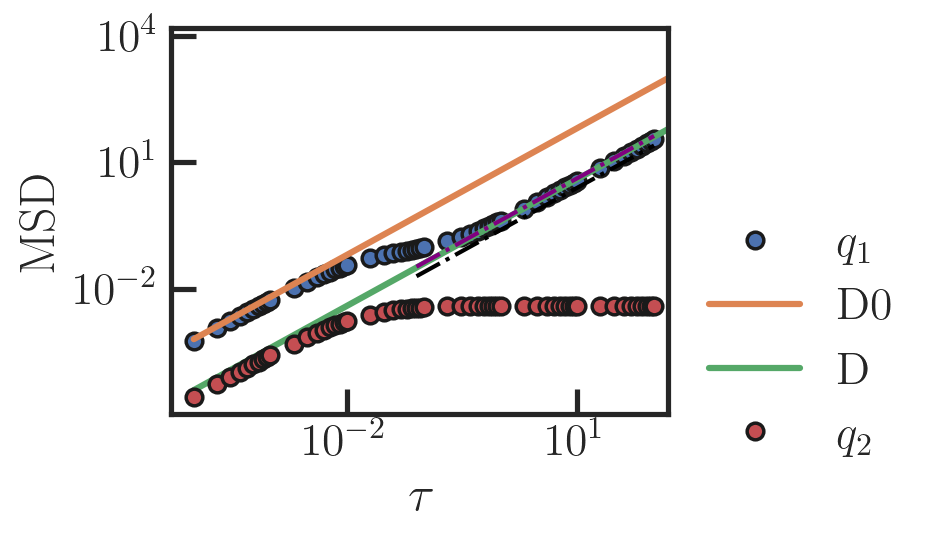

In [21]:
fig, ax = plt.subplots(figsize=(5, 3))

# Plot the MSD loglog
ax.loglog(t * tau, msd_q1, "o", markersize=6, label="$q_1$")
ax.loglog(t * tau, 2 * t * tau * D0[0], label="D0")
ax.loglog(t * tau, 2 * t * tau / gamma_11, label="D")

ax.loglog(t * tau, msd_q2, "o", markersize=6, label="$q_2$")

# Plot the theoretical lines
ax.plot(t[25:55] * tau, 2 * dlist[0] * t[25:55] * tau, "-.", linewidth=1.5, color='black')#, label="LJ")
ax.plot(t[25:55] * tau, 2 * dlist[1] * t[25:55] * tau, "-.", linewidth=1.5, color='purple')#, label="DLJ")

# Labels and legend
ax.set_xlabel("$\\tau$")
ax.set_ylabel("MSD")
ax.legend(frameon=False, loc='best', bbox_to_anchor=(1.0, 0.6))

# Grid and layout settings
# ax.grid(True, which="both", linestyle="--", linewidth=0.5)
fig.tight_layout()
plt.xlim(.5e-4, 1.5e2)
# plt.ylim(.3e-3, .5e2)

# Save and display the plot
plt.savefig('msdfig3a.pdf', transparent=True)
plt.show()


# Figure 2 b) equilibrium distributions

In [9]:
Projection_q1 = Peq_projection1D_q1(np.linspace(0,l, N), beta, alpha, l)            # Theoretical Peq(q1)
Projection_q2 = Peq_projection1D_q2(np.linspace(-0.2, 0.2, N), beta, kappa)      # Theoretical Peq(q2)

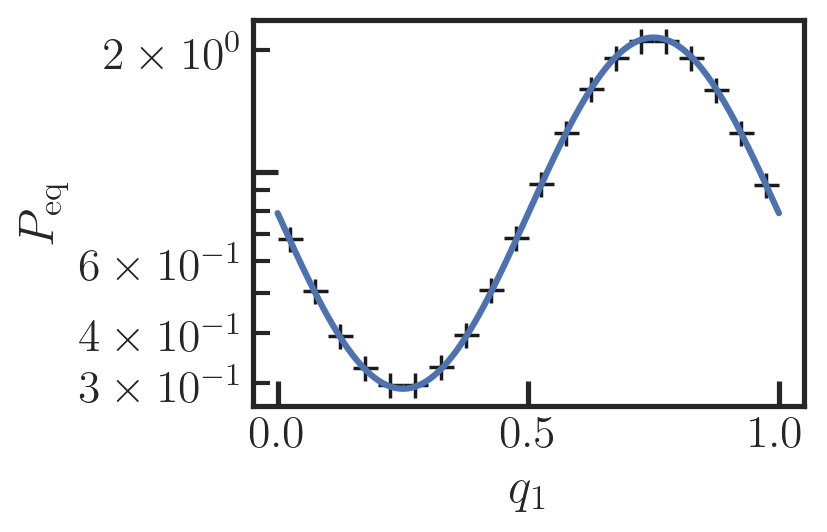

In [10]:
fig, ax = plt.subplots(figsize=(4.5, 3))

# Plot the histogram with semilog scale for the y-axis
ax.semilogy(q1_bins, q1_hist, "+", label="Histogram $q_1$")

# Plot the theoretical projection line
ax.plot(np.linspace(0, l, N), Projection_q1, color='b', label="Projection $q_1$")

# Hide y-axis tick labels for a cleaner look
ax.yaxis.set_ticklabels([])

# Labels and layout adjustments
ax.set_xlabel("$q_1$")
ax.set_ylabel("$P_\mathrm{eq}$")
# ax.legend(frameon=False, loc='best')

# Tight layout and saving the figure
fig.tight_layout()
plt.savefig('Peq.pdf', transparent=True)
plt.show()


# Same results in terms of kBT for visualisation purposes

/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_11091/3420846761.py:2: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  hist_normalized = -np.log(q1_hist / np.trapz(q1_hist, q1_bins))
/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_11091/3420846761.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  projection_normalized = -np.log(Projection_q1 / np.trapz(Projection_q1, np.linspace(0, 3 * l, N)))


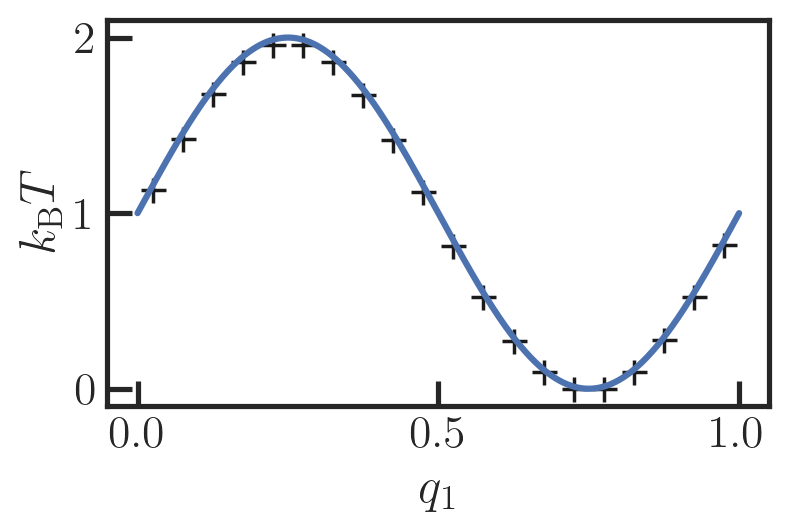

In [11]:
# Normalizing the histogram data and calculating the energy landscape
hist_normalized = -np.log(q1_hist / np.trapz(q1_hist, q1_bins))
hist_normalized -= np.min(hist_normalized)

# Normalizing the projection data and calculating the energy landscape
projection_normalized = -np.log(Projection_q1 / np.trapz(Projection_q1, np.linspace(0, 3 * l, N)))
projection_normalized -= np.min(projection_normalized)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(4.5, 3))

# Plot the histogram energy landscape
ax.plot(q1_bins, hist_normalized, "+", label="$histo (q_1)$", color='purple')

# Plot the theoretical projection energy landscape
ax.plot(np.linspace(0, l, N), projection_normalized, color="b", label="$\\propto \\exp(-\\beta \\phi_1(q_1))$")

# Add labels, grid, and legend
ax.set_xlabel("$q_1$")
ax.set_ylabel("$k_\mathrm{B} T$")
# ax.grid(True, linestyle="--", linewidth=0.5)
# ax.legend(frameon=False, loc='best')

fig.tight_layout()
plt.show()


# Processing and updating all CSV files to calculate their renormalisation coefficient (alpha in text) 

In [12]:
import pandas as pd
import os

# Define your custom coefficient calculation function
def calculate_coef(column):
    q1th = np.linspace(0, l, 1000)
    coef = calc_alpha_coefficient(q1th, alpha, l, gamma_ratio_11)
    return coef

folder_path = './results/'

# Process each CSV file in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)

        df = pd.read_csv(file_path)

        first_column = df.iloc[:, 0]
        alpha = first_column[7]
        l = first_column[6]
        gamma_11 = first_column[2] ** 2 + first_column[3] **2
        gamma_12 = first_column[3] * (first_column[2] + first_column[4])
        gamma_ratio_11 = gamma_12 / gamma_11
        # print (first_column)

        # Calculate the coefficient based on the first column
        coef = calculate_coef(first_column)
        print(coef)

        # Append the coef to the end of the first column
        df.loc[len(df)] = [coef] + [None] * (len(df.columns) - 1)  # Add coef to the end

        # Save the modified DataFrame back to the CSV file (overwrite)
        df.to_csv(file_path, index=False)

        print(f"Processed and updated {file_name} with coef: {coef}")


213.92969082266416
Processed and updated N_10000000-tau_0.0001-g11_1.0-g12_2.8-g22_10.0-kappa_0.0026-l_1.0-alpha_1.0-Ntrajectories_10.csv with coef: 213.92969082266416
285.11095972387113
Processed and updated N_10000000-tau_0.0001-g11_1.0-g12_2.3-g22_10.0-kappa_0.0011-l_1.0-alpha_1.0-Ntrajectories_10.csv with coef: 285.11095972387113
213.92969082266416
Processed and updated N_10000000-tau_0.0001-g11_1.0-g12_2.8-g22_10.0-kappa_0.0011-l_1.0-alpha_1.0-Ntrajectories_10.csv with coef: 213.92969082266416
202.52389897403742
Processed and updated N_10000000-tau_0.0001-g11_1.0-g12_2.9-g22_10.0-kappa_0.003-l_1.0-alpha_1.0-Ntrajectories_10.csv with coef: 202.52389897403742
285.11095972387113
Processed and updated N_10000000-tau_0.0001-g11_1.0-g12_2.3-g22_10.0-kappa_0.0026-l_1.0-alpha_1.0-Ntrajectories_10.csv with coef: 285.11095972387113
213.92969082266416
Processed and updated N_10000000-tau_0.0001-g11_1.0-g12_2.8-g22_10.0-kappa_0.002-l_1.0-alpha_1.0-Ntrajectories_10.csv with coef: 213.929690822

In [13]:
calculate_coef(alpha = 1., l = 1.0, gamma_ratio_11 = 6.5)


TypeError: calculate_coef() got an unexpected keyword argument 'alpha'

# Figure 3b) dictionaries to access MSD values (experimental and theoretical) 


In [40]:
import csv

# List of files to process
file_list_same_alpha = ['./results/same_alpha/N_10000000-tau_0.0001-g11_1.0-g12_2.6-g22_10.0-kappa_0.001-l_1.0-alpha_1.0-Ntrajectories_10.csv', 
                        './results/same_alpha/N_10000000-tau_0.0001-g11_1.0-g12_2.6-g22_10.0-kappa_0.0013-l_1.0-alpha_1.0-Ntrajectories_10.csv']  

file_list_same_kappa = [
                        './results/same_kappa/N_10000000-tau_0.0001-g11_1.0-g12_1.6-g22_10.0-kappa_0.0007-l_1.0-alpha_1.0-Ntrajectories_10.csv',
                        './results/same_kappa/N_10000000-tau_0.0001-g11_1.0-g12_2.2-g22_10.0-kappa_0.0007-l_1.0-alpha_1.0-Ntrajectories_10.csv',
                        './results/same_kappa/N_10000000-tau_0.0001-g11_1.0-g12_2.6-g22_10.0-kappa_0.0007-l_1.0-alpha_1.0-Ntrajectories_10.csv',] 



parameters_dict_kappa = {}
dlist_dict_kappa = {}
msd_q1_dict_kappa = {}

for result_file in file_list_same_kappa:
    parameters = []
    dlist = []
    msd_q1 = []
    with open(result_file) as f:
        reader = csv.reader(f, delimiter=',')
        next(reader, None)  # Skip the header
        for row in reader:
            if any(row[0]):
                parameters.append(float(row[0]))
            if any(row[3]):
                dlist.append(float(row[3]))
            if any(row[4]):
                msd_q1.append(float(row[4]))

    parameters_dict_kappa[result_file] = parameters
    dlist_dict_kappa[result_file] = dlist
    msd_q1_dict_kappa[result_file] = msd_q1

parameters_dict_alpha = {}
dlist_dict_alpha = {}
msd_q1_dict_alpha = {}

for result_file in file_list_same_alpha:
    parameters = []
    dlist = []
    msd_q1 = []
    
    with open(result_file) as f:
        reader = csv.reader(f, delimiter=',')
        next(reader, None)  # Skip the header
        for row in reader:
            if any(row[0]):
                parameters.append(float(row[0]))
            if any(row[3]):
                dlist.append(float(row[3]))
            if any(row[4]):
                msd_q1.append(float(row[4]))

    parameters_dict_alpha[result_file] = parameters
    dlist_dict_alpha[result_file] = dlist
    msd_q1_dict_alpha[result_file] = msd_q1


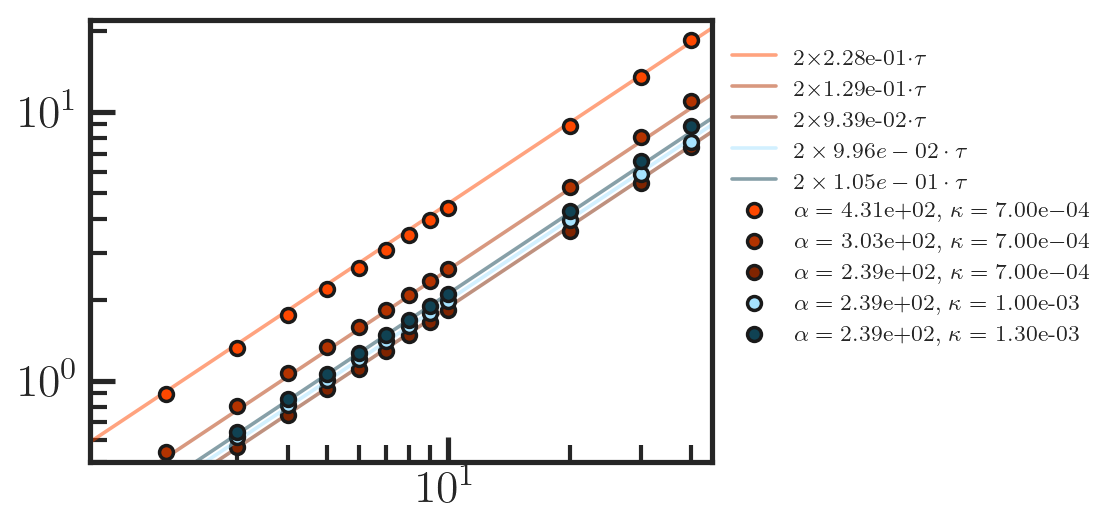

In [57]:
plt.figure(figsize=(4, 3))  # Increased figure width to accommodate the legends on the right

# Colors for kappa lines
colour_kappa = ['#ff4800', '#b33300', '#7f2400']
colour_picker_kappa = 0
t = np.hstack([np.arange(10 ** i, 10 ** (i + 1), 10 ** i) for i in range(7)])
tau = 1e-4

# Lists to store line and marker handles separately for creating separate legends
line_handles = []
marker_handles = []

# Loop for kappa values
for result_file, msd_q1 in msd_q1_dict_kappa.items():
    D_deanlj_resultfile = dlist_dict_kappa[result_file][1]
    last_parameter_value = f"{parameters_dict_kappa[result_file][-1]:.2e}"
    equation_label = f"\(2 \\times \){D_deanlj_resultfile:.2e}\( \cdot \\tau\)"
    
    # Plot the lines and markers separately to store handles
    line_plot, = plt.loglog(t * tau, 2 * D_deanlj_resultfile * t * tau, label=equation_label,
                            color=colour_kappa[colour_picker_kappa], linewidth=1.3, alpha=0.5)
    marker_plot, = plt.loglog(t * tau, msd_q1, 'o', label=f'\(\\alpha = \) {last_parameter_value}, \(\\kappa = 7.00\)e\(-04\)',
                              linewidth=0.8, color=colour_kappa[colour_picker_kappa], markersize=5)
    
    line_handles.append(line_plot)
    marker_handles.append(marker_plot)
    colour_picker_kappa += 1

# Colors for alpha lines
colour_alpha = ['#a6e3ff', '#104253']
colour_picker_alpha = 0

# Loop for alpha values
for result_file, msd_q1 in msd_q1_dict_alpha.items():
    D_deanlj_resultfile = dlist_dict_alpha[result_file][1]
    last_parameter_value = f"{parameters_dict_alpha[result_file][5]:.2e}"
    equation_label = f"\(2 \\times {D_deanlj_resultfile:.2e} \cdot \\tau\)"
    
    # Plot the lines and markers separately to store handles
    line_plot, = plt.loglog(t * tau, 2 * D_deanlj_resultfile * t * tau, label=equation_label,
                            linewidth=1.3, color=colour_alpha[colour_picker_alpha], alpha=0.5)
    marker_plot, = plt.plot(t * tau, msd_q1, 'o', label=f'\(\\alpha = 2.39\)e\(+02\), \(\kappa = \) {last_parameter_value}',
                            color=colour_alpha[colour_picker_alpha], markersize=5)
    
    line_handles.append(line_plot)
    marker_handles.append(marker_plot)
    colour_picker_alpha += 1

# Set plot limits and layout
plt.xlim(1.3, 45)
plt.ylim(0.5, 22)
plt.tight_layout()

# Create a combined legend for both lines and markers, positioned on the right outside the plot
plt.legend(handles=line_handles + marker_handles, prop={'size': 8}, frameon=False, loc='center left', bbox_to_anchor=(1.0, 0.6))

# Save the figure
plt.savefig('fig3b.pdf', format='pdf', transparent=True, bbox_inches='tight')

# Show the plot
plt.show()



# Extracting all the values for figure 4 in dictionaries

In [42]:
parent_folder = './results/'
subfolders = [
    '213.92969082266416', '239.37720085908657', '253.54995339536853',
    '268.7748464338846', '302.60715902920464', '341.17681728880797',
    '362.2137078255198', '430.7244253109555'
]

# Dictionary to store extracted values
extracted_values = {subfolder: {} for subfolder in subfolders}

# Process each subfolder
for subfolder in subfolders:
    subfolder_path = os.path.join(parent_folder, subfolder)

    # Iterate over each file in the subfolder
    for filename in os.listdir(subfolder_path):
        with open(os.path.join(subfolder_path, filename), 'r') as f:
            rows = list(csv.reader(f))
            
            if len(rows) > 5:
                # Extract values directly
                deltadexp = (float(rows[1][1]) / 2 - float(rows[1][3])) / float(rows[1][3])
                extracted_values[subfolder][filename] = {
                    'deltad': deltadexp,
                    'deltadtheo': float(rows[3][3]),
                    'kappa': float(rows[6][0]),
                    'coef': float(rows[-1][0])
                }

In [43]:
# Collect data for plotting
deltad_values = []
deltadtheo_values = []
coef_values = []
kappa_values = []

for subfolder, files in extracted_values.items():
    for filename, values in files.items():
        if isinstance(values, dict):
            deltad = values['deltad']
            deltadtheo = values['deltadtheo']
            coef = values['coef']
            kappa = values['kappa']



            deltad_values.append(deltad)
            deltadtheo_values.append(deltadtheo)
            coef_values.append(coef)
            kappa_values.append(kappa)

/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_15767/2786884994.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(prop={'size': 15}, frameon=False)


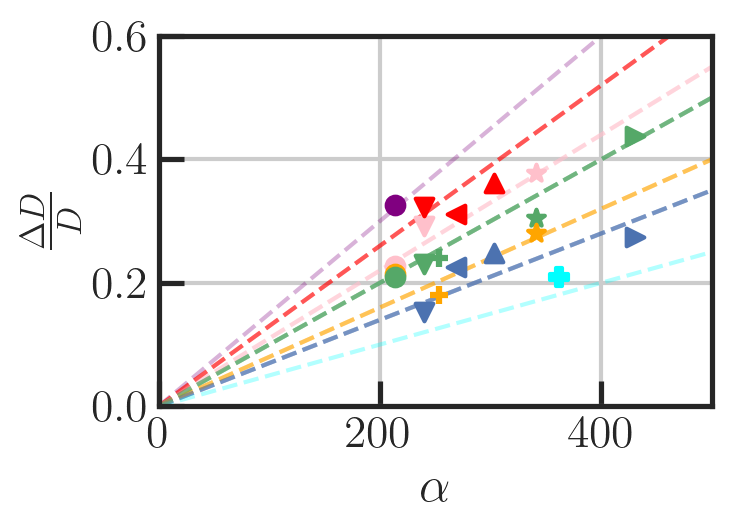

In [58]:

plt.figure(figsize=(4, 3))

# Define the shape and color mappings to make the code cleaner
shape_mapping = {
    213.92969082266416: "o",
    239.37720085908657: "v",
    253.54995339536853: "+",
    268.7748464338846: "<",
    302.60715902920464: "^",
    341.17681728880797: "*",
    362.2137078255198: "P",
    430.7244253109555: ">"
}

color_mapping = {
    0.0005: 'cyan',
    0.0007: 'b',
    0.0008: 'orange',
    0.001: 'g',
    0.0011: 'pink',
    0.0013: 'red',
    0.0015: 'purple'
}

# Loop through the data points and plot each line and scatter point
for coef, kappa, delta_theo, delta in zip(coef_values, kappa_values, deltadtheo_values, deltad_values):
    shape = shape_mapping.get(coef, "o")  # Default shape if coef is not in the mapping
    color = color_mapping.get(kappa, 'black')  # Default color if kappa is not in the mapping

    # Plot the line with a lower zorder so it appears behind the markers
    plt.plot(5*np.linspace(0, coef), 
             5*np.linspace(0, delta_theo), 
             color=color, linestyle='--', linewidth=1.5, zorder=1, alpha = .3)

    # Plot the scatter point with a higher zorder to ensure it is on top of the line
    plt.scatter(coef, delta, color=color, marker=shape, s=40, zorder=2)

# Set plot labels, limits and grid
plt.xlabel('$\\alpha$')
plt.xlim(0, 500)
plt.ylabel('$\\frac{\\Delta D}{D}$')
plt.ylim(0, .6)
plt.grid(True)

plt.tight_layout()
plt.legend(prop={'size': 15}, frameon=False)

# Save the figure
plt.savefig('fig4a.pdf', transparent=True)

# Display the plot
plt.show()




/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_15767/4143541875.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(prop={'size': 15}, frameon=False)


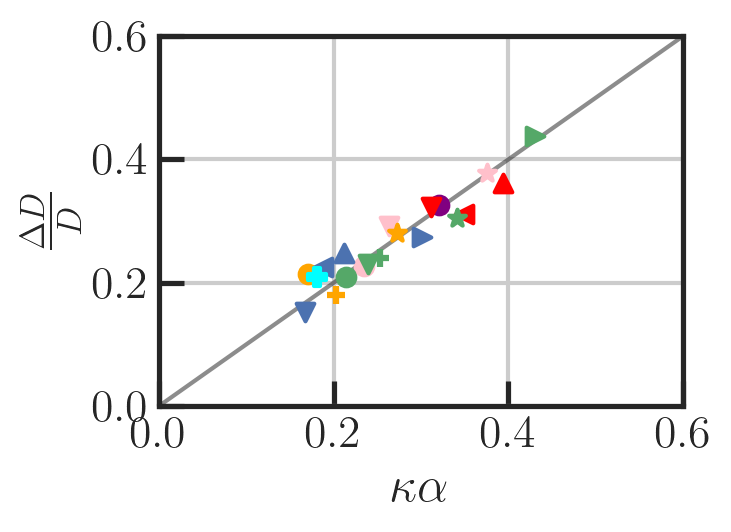

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure size
plt.figure(figsize=(4, 3))

# Define the shape and color mappings to make the code cleaner
shape_mapping = {
    213.92969082266416: "o",
    239.37720085908657: "v",
    253.54995339536853: "+",
    268.7748464338846: "<",
    302.60715902920464: "^",
    341.17681728880797: "*",
    362.2137078255198: "P",
    430.7244253109555: ">"
}

color_mapping = {
    0.0005: 'cyan',
    0.0007: 'b',
    0.0008: 'orange',
    0.001: 'g',
    0.0011: 'pink',
    0.0013: 'red',
    0.0015: 'purple'
}

# Loop through the data points and plot each line and scatter point
for coef, kappa, delta_theo, delta in zip(coef_values, kappa_values, deltadtheo_values, deltad_values):
    shape = shape_mapping.get(coef, "o")  # Default shape if coef is not in the mapping
    color = color_mapping.get(kappa, 'black')  # Default color if kappa is not in the mapping
    # Plot the scatter point with a higher zorder to ensure it is on top of the line
    plt.scatter(kappa*coef, delta, color=color, marker=shape, s=40,zorder=2)

plt.plot(5*np.linspace(0, kappa*coef), 
             5*np.linspace(0, delta_theo), 
             color='k', linestyle='-', linewidth=1.5, zorder=1, alpha = .5)
    
# Set plot labels, limits and grid
plt.xlabel('$\\kappa\\alpha$')
plt.xlim(0, .6)
plt.ylabel('$\\frac{\\Delta D}{D}$')
plt.ylim(0, .6)
plt.grid(True)
plt.tight_layout()

# Customize the legend (if needed)
plt.legend(prop={'size': 15}, frameon=False)

# Save the figure
plt.savefig('fig4b.pdf', transparent=True)

# Display the plot
plt.show()